In [1]:
import os, platform, time
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

C:\Users\mathi\AppData\Local\Temp\ipykernel_1876\1947495857.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Global Paramters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 120
EPOCHS = 5
LEARNING_RATE = 0.001

In [21]:
train_data_path = None
labels_path = None
platform_name = platform.system()
number_of_classes = None
#number_of_classes = 10
total_samplesize_proportion = 1
#size according to AlexNet - Wikipedia
size = (224,224)
np.random.seed(seed=42)
pathfunpics = 'C:/Users/mathi/OneDrive/Desktop/CAS Machine Intelligence/Deep Learning/Project/funpicture'
print("\nName of the OS system:", platform_name)

# defining the paths and files 
if (platform_name == 'Darwin'):
  train_data_path  = '/Users/vito/Documents/Datenanalyse/ZHAW/04__CAS_Machine_Intelligence/02_Deep_Learning/__Project/00_Data/dog-breed-identification/train'   
  labels_path = '/Users/vito/Documents/Datenanalyse/ZHAW/04__CAS_Machine_Intelligence/02_Deep_Learning/__Project/00_Data/dog-breed-identification/labels.csv'
elif (platform_name == 'Windows'): 
  train_data_path = 'C:/Users/mathi/OneDrive/Desktop/CAS Machine Intelligence/Deep Learning/Project/train'
  labels_path = 'C:/Users/mathi/OneDrive/Desktop/CAS Machine Intelligence/Deep Learning/Project/labels.csv'
else:
  raise Exception('Unsupported platform "{}"'.format(platform_name))
print(f'{train_data_path = }')
print(f'{labels_path = }')

# setting the batchsize for images loading
batch_size = 10


Name of the OS system: Windows
train_data_path = 'C:/Users/mathi/OneDrive/Desktop/CAS Machine Intelligence/Deep Learning/Project/train'
labels_path = 'C:/Users/mathi/OneDrive/Desktop/CAS Machine Intelligence/Deep Learning/Project/labels.csv'


In [4]:
# load class labels from CSV file into a DataFrame
labels_df = pd.read_csv(labels_path)
# set identifier column as key
labels_df.set_index('id',inplace=True)
# Get all unique categories from column 'breed'
breeds = labels_df['breed'].unique()
total_number_of_classes = len(breeds)
#print(breeds)
# sort breeds in order to specify of target vector Y
breeds_sorted = np.sort(breeds)
num_classes = len(breeds)
print(f'{num_classes = }')

if number_of_classes is not None:
    random_breed = np.random.choice(breeds_sorted,size=number_of_classes,replace=False, p=None)
    random_breed_sorted = np.sort(random_breed)
else:
    random_breed_sorted = breeds_sorted
num_classes = len(random_breed_sorted)
print(f'{num_classes = }')

num_classes = 120
num_classes = 120


In [5]:
# Determine the counts of each breed and return the minimum and maximum counts
counts = labels_df['breed'].value_counts()
#print(counts)
mincount = counts.min()
maxcount = counts.max() 
print(f'mincount = {mincount}, maxcount = {maxcount}')

mincount = 66, maxcount = 126


In [6]:
# Initialize an empty DataFrame to store the sampled rows
sampled_df = pd.DataFrame()

# For each category
for breed in random_breed_sorted:
    # Filter the DataFrame for the current category
    breed_df = labels_df[labels_df['breed'] == breed]
    # Randomly select 2 rows from the filtered DataFrame
    sampled_rows = breed_df.sample(n=int(counts[breed]*total_samplesize_proportion), random_state=42,replace=False)
    
    # Append the sampled rows to the new DataFrame
    sampled_df = pd.concat([sampled_df, sampled_rows])
 
#sampled_min_df['id'] = sampled_min_df['id'] + '.jpg'
print(sampled_df.head())
print(f'\n{sampled_df.shape = }')
print()
print(sampled_df['breed'].value_counts())

                                          breed
id                                             
5b154e409fe61a86f37e842480f44a10  affenpinscher
00ca18751837cd6a22813f8e221f7819  affenpinscher
4a6cff93d44190c7e2410799f729a4d0  affenpinscher
5cb8e8855145375221015c02fe21b273  affenpinscher
32249ae4f7590aede350e2b08b322ac4  affenpinscher

sampled_df.shape = (10222, 1)

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: count, Length: 120, dtype: int64


In [7]:
# we will use the file basename without file extension as key
# NOTE: This function will use the following variables from above: "labels_df", "breeds_sorted" and "num_classes"
def load_images_in_folder(breeds_id_list,breeds_sorted,folder_path,batch_size=10,size=(200,200)):    
    file_list_all = os.listdir(folder_path)
    file_list = [file for file in file_list_all if Path(file).stem in breeds_id_list] 
    # NOTE: for DEV only, needs to be commented out in production
    #file_list = os.listdir(folder_path)[0:1000]
    num_batches = (len(file_list) + batch_size - 1) // batch_size
    #'''
    for i in range(num_batches):
        batch_files = file_list[i * batch_size : (i + 1) * batch_size]
        batch_images_dict = {}
        for filename in batch_files:
            filepath = os.path.join(folder_path, filename)
            try:
                with Image.open(filepath) as image:
                    # copy image as array and scale accordingly                    
                    id       = Path(filename).stem
                    breed    = labels_df.loc[id,'breed']
                    class_no = np.searchsorted(breeds_sorted,breed)                    
                    batch_images_dict[id] = dict(X=np.array(tf.keras.preprocessing.image.smart_resize(image,size,interpolation='bilinear'))/255,Y=to_categorical(class_no,num_classes),breed=breed)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
        yield batch_images_dict

In [8]:
start = time.time()
dog_images_dict = {}
for batch in load_images_in_folder(sampled_df.index,random_breed_sorted,train_data_path,batch_size=batch_size,size=size):
    dog_images_dict.update(zip(batch.keys(),batch.values()))

end = time.time()
elapsed = end - start
print(f'\nTime taken for "dog_images_dict" generation: {elapsed:.6f} seconds')    


Time taken for "dog_images_dict" generation: 100.773961 seconds


In [9]:
num_samples = len(dog_images_dict)
key_0     = list(dog_images_dict.keys())[0]
shape_0_X = dog_images_dict[key_0]['X'].shape
shape_0_Y = dog_images_dict[key_0]['Y'].shape

# Initialize empty array with specific dimensions for means of performance 
X_Inital = np.zeros([num_samples,shape_0_X[0],shape_0_X[1],shape_0_X[2]])
Y_Inital = np.zeros([num_samples,shape_0_Y[0]])
i = 0
start = time.time()
for sample in dog_images_dict.values(): 
    x = sample['X']
    y = sample['Y']
    X_Inital[i] = x 
    Y_Inital[i] = y
    print('',i,'',end='') if (i%100==0) else print('.',end='')
    i = i + 1

end = time.time()
elapsed = end - start
print(f'\nTime taken for "X_Inital" and "Y_Inital": {elapsed:.6f} seconds')

 0 ................................................................................................... 100 ................................................................................................... 200 ................................................................................................... 300 ................................................................................................... 400 ................................................................................................... 500 ................................................................................................... 600 ................................................................................................... 700 ................................................................................................... 800 ................................................................................................... 900 .............................................................

In [10]:
# print shape of the basis tensors
print(f'{X_Inital.shape = }')
print(f'{Y_Inital.shape = }')

X_Inital.shape = (10222, 224, 224, 3)
Y_Inital.shape = (10222, 120)


In [11]:
# split training data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X_Inital, Y_Inital, test_size=0.2, random_state=1)
# split training data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [12]:
# print number of occurence per class
print('y_train:',np.sum(y_train, axis=0))
print('y_test:',np.sum(y_test, axis=0))
print('y_val:', np.sum(y_val, axis=0))

y_train: [38. 65. 53. 62. 48. 52. 66. 78. 47. 63. 53. 69. 46. 58. 49. 55. 35. 59.
 40. 44. 49. 45. 38. 43. 44. 44. 68. 46. 57. 42. 55. 53. 48. 52. 45. 53.
 48. 48. 45. 54. 55. 51. 71. 42. 39. 46. 45. 57. 39. 37. 46. 48. 68. 48.
 49. 56. 46. 51. 49. 58. 63. 62. 48. 54. 51. 38. 41. 45. 62. 62. 54. 46.
 51. 61. 48. 67. 40. 55. 53. 60. 60. 47. 47. 38. 48. 50. 57. 63. 57. 49.
 55. 35. 48. 57. 61. 56. 53. 62. 55. 46. 77. 49. 55. 40. 46. 51. 47. 52.
 34. 64. 45. 46. 38. 38. 51. 47. 49. 50. 47. 43.]
y_test: [18. 28. 15. 25. 15. 16. 19. 18. 15. 19. 17. 22. 13. 23. 20. 14. 15. 19.
 22. 27. 15. 13. 18. 15. 14. 15. 22. 15. 15. 17. 18. 13. 15. 13. 12. 17.
 16. 13. 13. 17. 15. 11. 19. 12. 18. 15. 15.  4. 15. 15. 18. 17. 23. 20.
 17. 20. 20. 11. 12. 21. 15. 16. 13. 17. 18. 11. 14. 20. 23. 20. 17. 16.
 10. 37. 17. 18. 17. 11. 15. 12. 19. 16. 18. 17. 29. 15. 13. 25. 16.  9.
 14. 24. 13. 21. 28. 14. 12. 31. 17. 12. 16. 22. 18. 20. 14. 17. 14. 13.
 14. 22. 17. 19. 15. 14. 13. 16. 13. 23. 20. 21.]
y_val: 

In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((6132, 224, 224, 3),
 (6132, 120),
 (2045, 224, 224, 3),
 (2045, 120),
 (2045, 224, 224, 3),
 (2045, 120))

In [14]:
# ----------Transferlearning with MobileNetV2 -----
#  Load pre-trained MobileNetV2 model no top loayers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#   Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# new model
model_plain = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
model_plain.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# trainloop
history = model_plain.fit(
    x_train, y_train,
    epochs=EPOCHS,
    validation_data= (x_val, y_val)
)

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 98s 487ms/step - accuracy: 0.4725 - loss: 2.3855 - val_accuracy: 0.7408 - val_loss: 0.8590
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 94s 491ms/step - accuracy: 0.8598 - loss: 0.4361 - val_accuracy: 0.7379 - val_loss: 0.8738
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 95s 495ms/step - accuracy: 0.9233 - loss: 0.2469 - val_accuracy: 0.7692 - val_loss: 0.7805
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 91s 476ms/step - accuracy: 0.9647 - loss: 0.1204 - val_accuracy: 0.7687 - val_loss: 0.8358
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 92s 479ms/step - accuracy: 0.9799 - loss: 0.0787 - val_accuracy: 0.7932 - val_loss: 0.7339


In [15]:
#eval
loss, accuracy = model_plain.evaluate(x=x_test,y=y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.8029 - loss: 0.7473
Test loss: 0.7662
Test accuracy: 0.8015


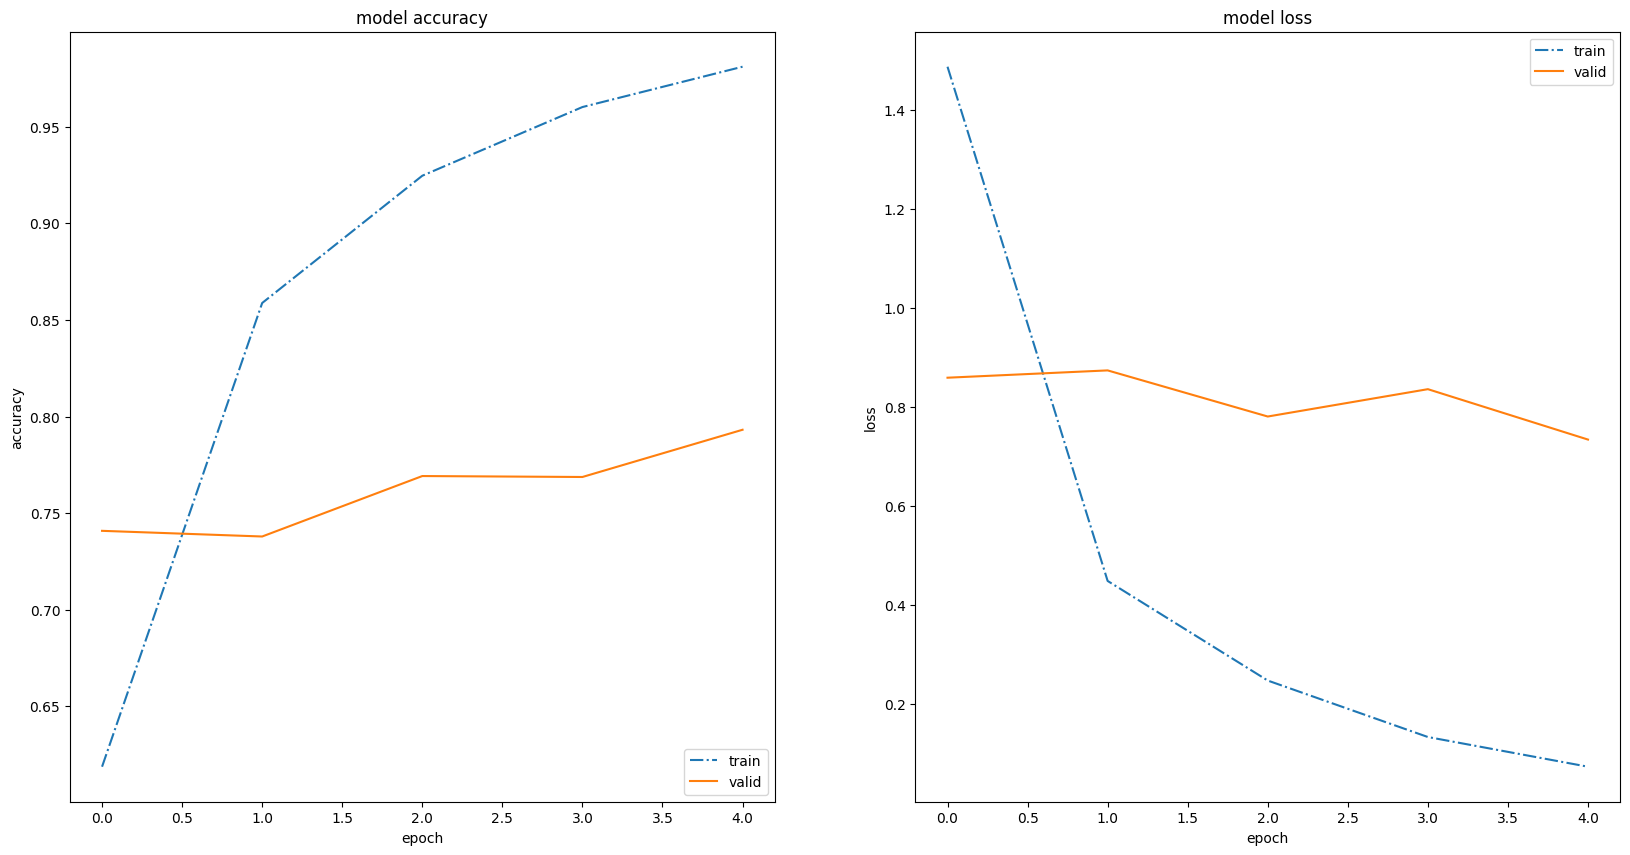

In [16]:
# plot the development of the accuracy and loss during training
figsize=(20,10)
plt.figure(figsize=figsize)
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [17]:
#class_labels = breeds_sorted
# predict each instance of the testset
pred=model_plain.predict(x_test)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
 
acc_fc = np.sum(np.argmax(y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=random_breed_sorted)

64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step
Accuracy =  0.8014669926650366


Text(0.5, 1.0, 'Confusion Matrix')

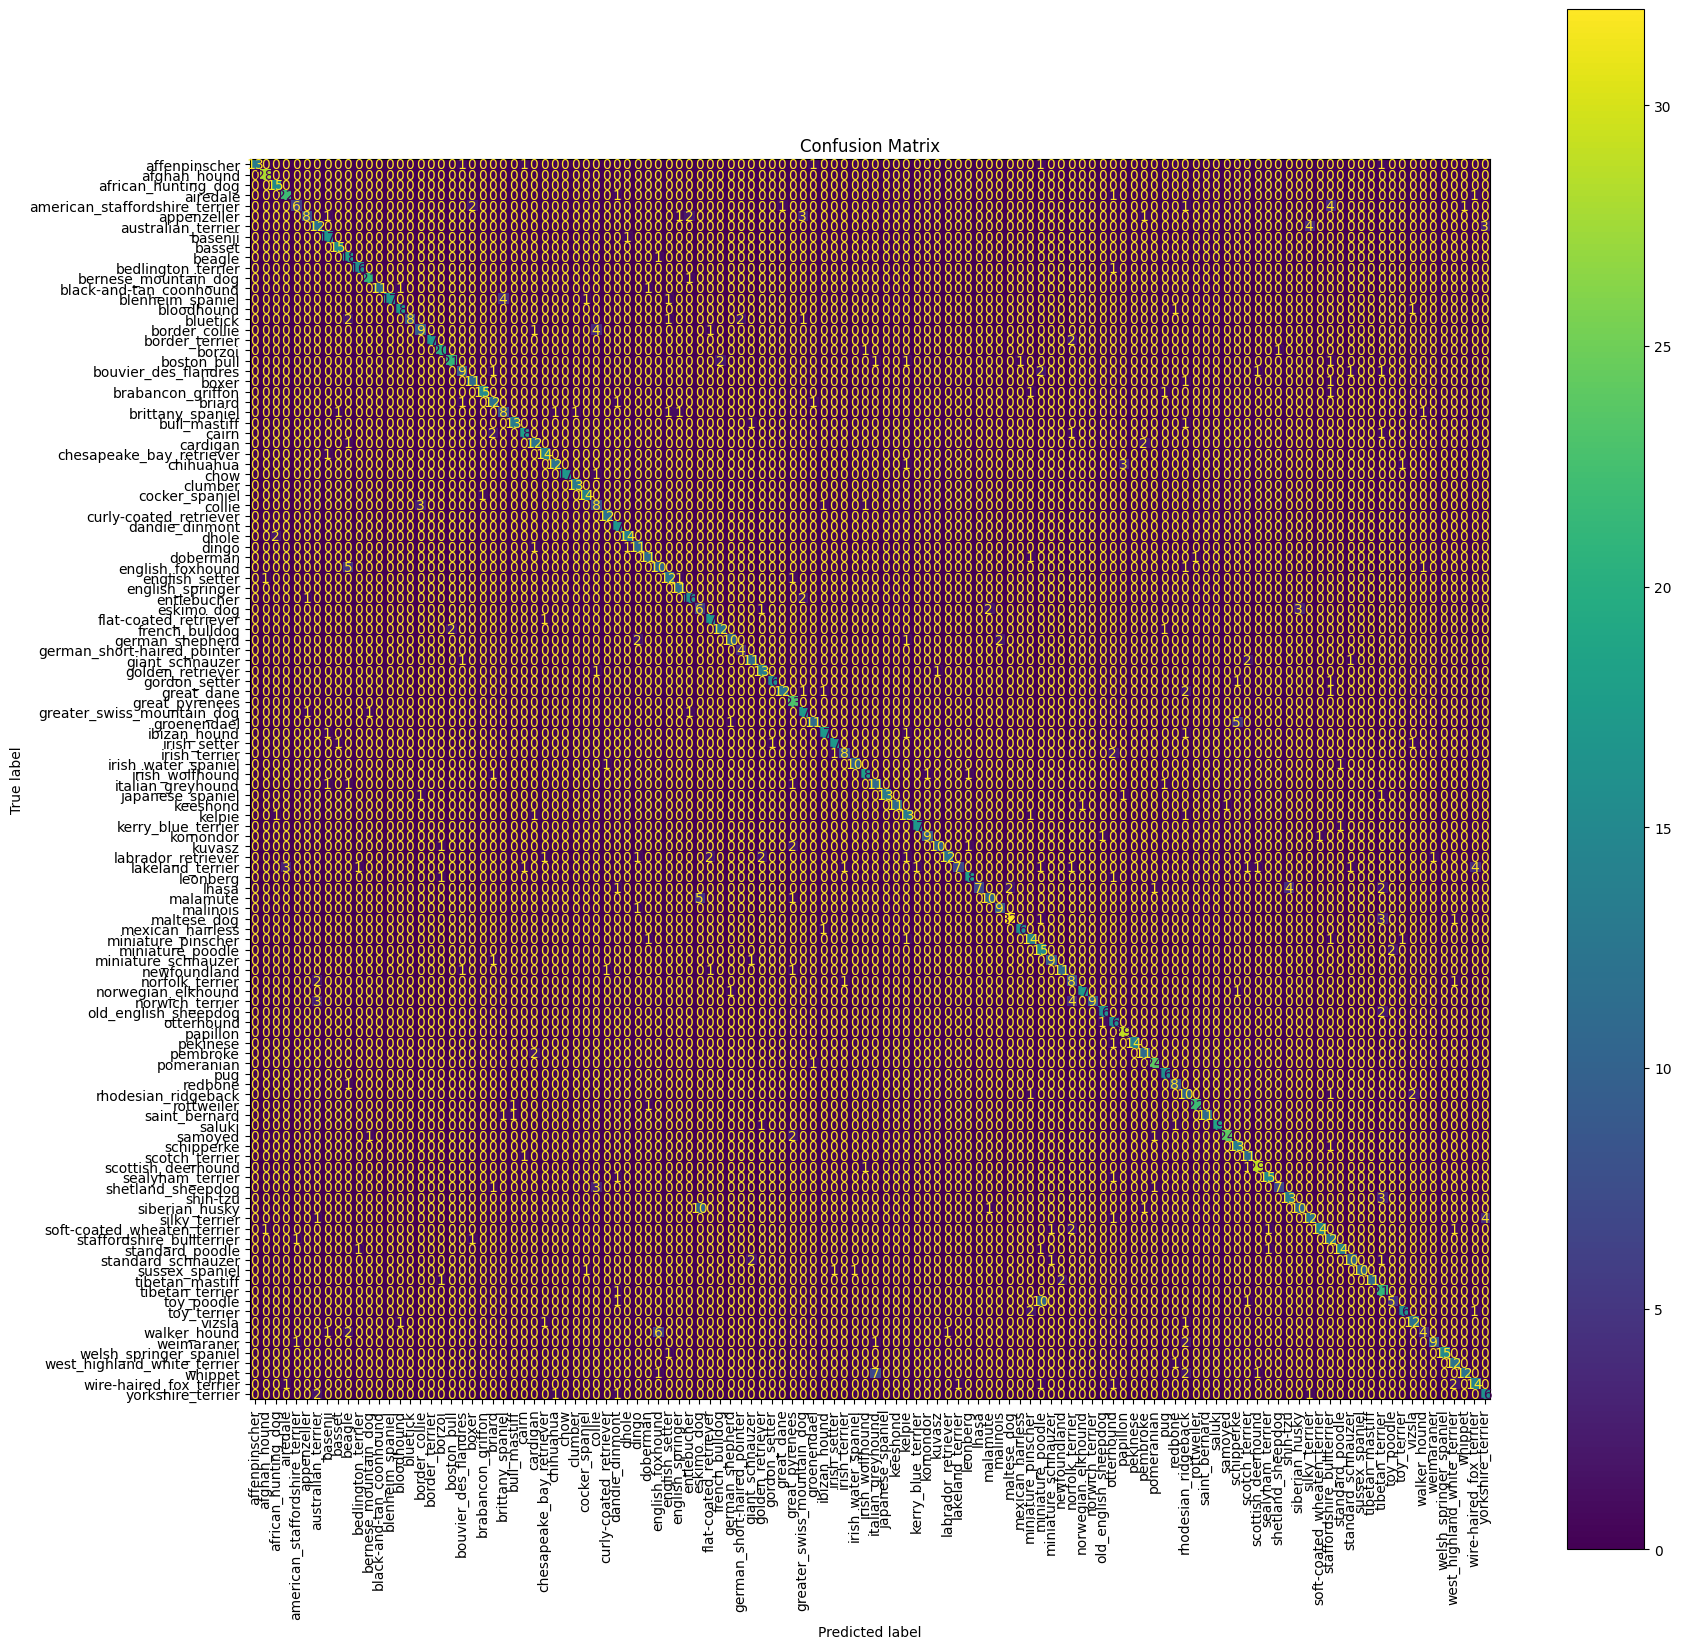

In [18]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(cmap='viridis',ax=ax,xticks_rotation='vertical')
plt.title('Confusion Matrix')

In [19]:
print('Baseline Accuracy:',1/num_classes)

Baseline Accuracy: 0.008333333333333333


In [36]:
# List all files in the directory
files = os.listdir(pathfunpics)

# Filter out only the jpg files
jpg_files = [file for file in files if file.endswith('.jpg')]

# Initialize an empty list to store the images as numpy arrays
image_array_list = []

# Loop through each jpg file, load it, and convert it to a numpy array
for jpg_file in jpg_files:
    # Construct the full path to the image file
    file_path = os.path.join(pathfunpics, jpg_file)
    
    # Open the image file using PIL
    image = Image.open(file_path)
    
    # Convert the image to a numpy array
    image_array = np.array(tf.keras.preprocessing.image.smart_resize(image,size,interpolation='bilinear'))/255
    
    # Append the numpy array to the list
    image_array_list.append(image_array)

x_fun = np.array(image_array_list)

In [42]:
pred=model_plain.predict(x_fun)
pred_breed = [random_breed_sorted[np.argmax(pred[i])] for i in range(len(pred))]

print(jpg_files[0], pred_breed[0])
print(jpg_files[1], pred_breed[1])
print(jpg_files[2], pred_breed[2])
print(jpg_files[3], pred_breed[3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
01a_Hund_Vito.jpg labrador_retriever
01b_Hund_Mathieu.jpg toy_terrier
02a_Vito.jpg chihuahua
02b_Mathieu.jpg pug


In [56]:
# store variables to be used in other notebook for means of efficiency
# requires installation of package "pickleshare"
'''
%store x_train
%store y_train
%store counts
%store random_breed_sorted
'''

'\n%store x_train\n%store y_train\n%store counts\n%store random_breed_sorted\n'

In [57]:
# declare the image data generator (most parameter values are taken from the course notebook "07_cifar10_tricks.ipynb")
fill_mode='nearest'
#fill_mode='constant'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode=fill_mode,
cval=1,horizontal_flip=True)

In [58]:
# Show required augmentations for each class
print('{:30s} {:10s} {:15s}\n'.format('breed','num_samples','augmentations required'))
for key, value in counts.items(): 
  print('{:30s} {:10g} {:15g}'.format(key,value,maxcount-value))   

breed                          num_samples augmentations required

scottish_deerhound                    126               0
maltese_dog                           117               9
afghan_hound                          116              10
entlebucher                           115              11
bernese_mountain_dog                  114              12
shih-tzu                              112              14
great_pyrenees                        111              15
pomeranian                            111              15
basenji                               110              16
samoyed                               109              17
airedale                              107              19
tibetan_terrier                       107              19
leonberg                              106              20
cairn                                 106              20
beagle                                105              21
japanese_spaniel                      105              21
austr

In [59]:
# generates augmented images from specific class
def generate_augmentation_for_class(X_class,Y_class,num_images,random_seed):
    X_aug = None
    Y_aug = None
    img_aug = datagen.flow(x=X_class,y=Y_class,batch_size=1,seed=random_seed) 
    for i in range(0,num_images):       
        x,y=next(img_aug)     
        if X_aug is not None:
            X_aug = np.append(X_aug,x.astype('int'),axis=0)
            Y_aug = np.append(Y_aug,y.astype('int'),axis=0)  
        else:
            X_aug = x.astype('int')
            Y_aug = y.astype('int')
    return X_aug, Y_aug

In [62]:
# generate dict for storing training tensor indices for each class
breed_index_dict = {}
# initialize dict
for breed in random_breed_sorted:
   breed_index_dict[breed] = [] 

num_samples = len(y_train)
#print(f'{num_samples = }')
for i in range(num_samples): 
    # get index position of value 1
    j = np.argmax(y_train[i])
    # get breed class by index
    breed = random_breed_sorted[j]
    # append sample index i to list
    breed_index_dict[breed].append(i)
    #print(f'{i = } {j = } {breed = }')

#breed_index_dict
#plt.imshow(x_train[breed_index_dict['affenpinscher']][45])
#print(len(breed_index_dict['american_staffordshire_terrier']))
#plt.imshow(x_train[breed_index_dict['american_staffordshire_terrier']][44])


#np.sum(y_train[breed_index_dict['american_staffordshire_terrier']], axis=0)

In [63]:
random_seed=87

x_aug = None
y_aug = None

start = time.time()
for breed in random_breed_sorted:
    print(f'{breed = }',end='')
    value = counts[breed]
    print(f' num_samples = {value}',end='')
    num_augmentations = maxcount-value
    need_augmentation = (num_augmentations>0)
    print(f' {need_augmentation = } {num_augmentations = }')    
    if need_augmentation:
        class_idx = breed_index_dict[breed]
        X, Y = generate_augmentation_for_class(x_train[class_idx], y_train[class_idx],num_augmentations,random_seed)
        if x_aug is not None:        
            x_aug = np.append(x_aug,X,axis=0)
            y_aug = np.append(y_aug,Y,axis=0)         
        else:
            x_aug = X
            y_aug = Y

end = time.time()
elapsed = end - start
print(f'\nTime taken for data augmentation generation: {elapsed:.6f} seconds')

breed = 'affenpinscher' num_samples = 80 need_augmentation = True num_augmentations = 46
breed = 'afghan_hound' num_samples = 116 need_augmentation = True num_augmentations = 10
breed = 'african_hunting_dog' num_samples = 86 need_augmentation = True num_augmentations = 40
breed = 'airedale' num_samples = 107 need_augmentation = True num_augmentations = 19
breed = 'american_staffordshire_terrier' num_samples = 74 need_augmentation = True num_augmentations = 52
breed = 'appenzeller' num_samples = 78 need_augmentation = True num_augmentations = 48
breed = 'australian_terrier' num_samples = 102 need_augmentation = True num_augmentations = 24
breed = 'basenji' num_samples = 110 need_augmentation = True num_augmentations = 16
breed = 'basset' num_samples = 82 need_augmentation = True num_augmentations = 44
breed = 'beagle' num_samples = 105 need_augmentation = True num_augmentations = 21
breed = 'bedlington_terrier' num_samples = 89 need_augmentation = True num_augmentations = 37
breed = 'be

In [64]:
x_aug_train = np.append(x_aug,x_train,axis=0)
y_aug_train = np.append(y_aug,y_train,axis=0)   
x_aug_train.shape, y_aug_train.shape, x_aug.shape, y_aug.shape, x_train.shape, y_train.shape

((11030, 224, 224, 3), (11030, 120))

In [66]:
# new model
model_aug = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
model_aug.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# trainloop
history_aug = model_aug.fit(
    x_aug_train, y_aug_train,
    epochs=EPOCHS,
    validation_data= (x_val, y_val)
)

Epoch 1/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 195s 552ms/step - accuracy: 0.5359 - loss: 2.3927 - val_accuracy: 0.7501 - val_loss: 0.9587
Epoch 2/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 176s 512ms/step - accuracy: 0.5253 - loss: 2.2299 - val_accuracy: 0.7496 - val_loss: 1.0192
Epoch 3/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 170s 493ms/step - accuracy: 0.5464 - loss: 2.1223 - val_accuracy: 0.7359 - val_loss: 1.0566
Epoch 4/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 172s 499ms/step - accuracy: 0.5515 - loss: 2.0944 - val_accuracy: 0.7653 - val_loss: 1.0558
Epoch 5/5
345/345 ━━━━━━━━━━━━━━━━━━━━ 161s 466ms/step - accuracy: 0.5675 - loss: 2.0140 - val_accuracy: 0.7707 - val_loss: 1.0053


In [67]:
#eval
loss, accuracy = model_aug.evaluate(x=x_test,y=y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 422ms/step - accuracy: 0.7568 - loss: 1.1673
Test loss: 1.1733
Test accuracy: 0.7584


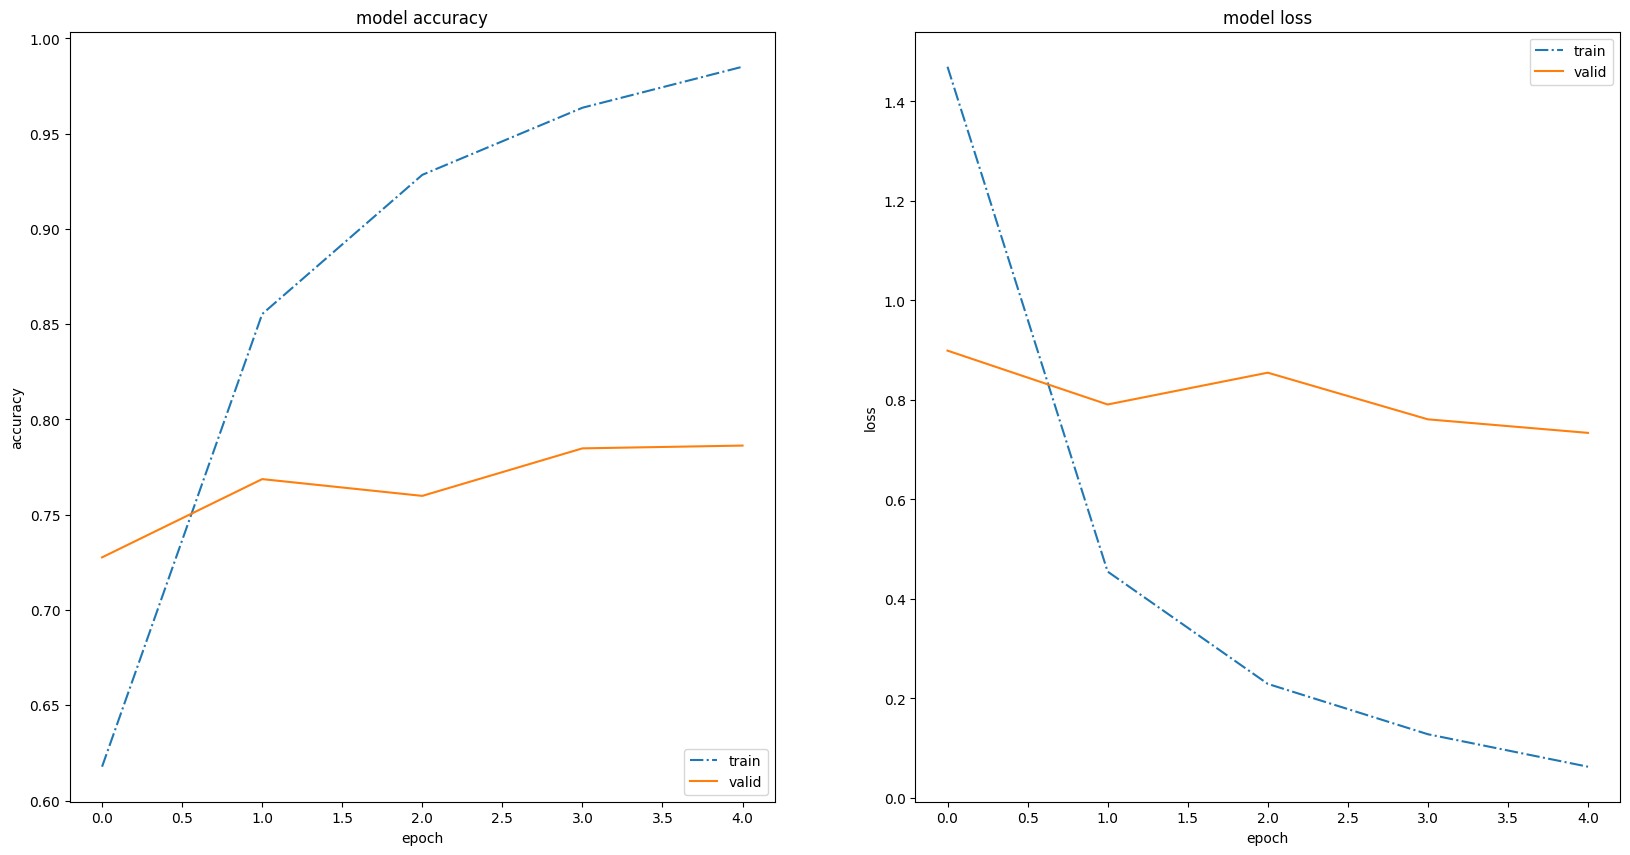

In [68]:
# plot the development of the accuracy and loss during training
figsize=(20,10)
plt.figure(figsize=figsize)
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [69]:
#class_labels = breeds_sorted
# predict each instance of the testset
pred=model_plain.predict(x_test)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
 
acc_fc = np.sum(np.argmax(y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=random_breed_sorted)

64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 433ms/step
Accuracy =  0.7584352078239609


Text(0.5, 1.0, 'Confusion Matrix')

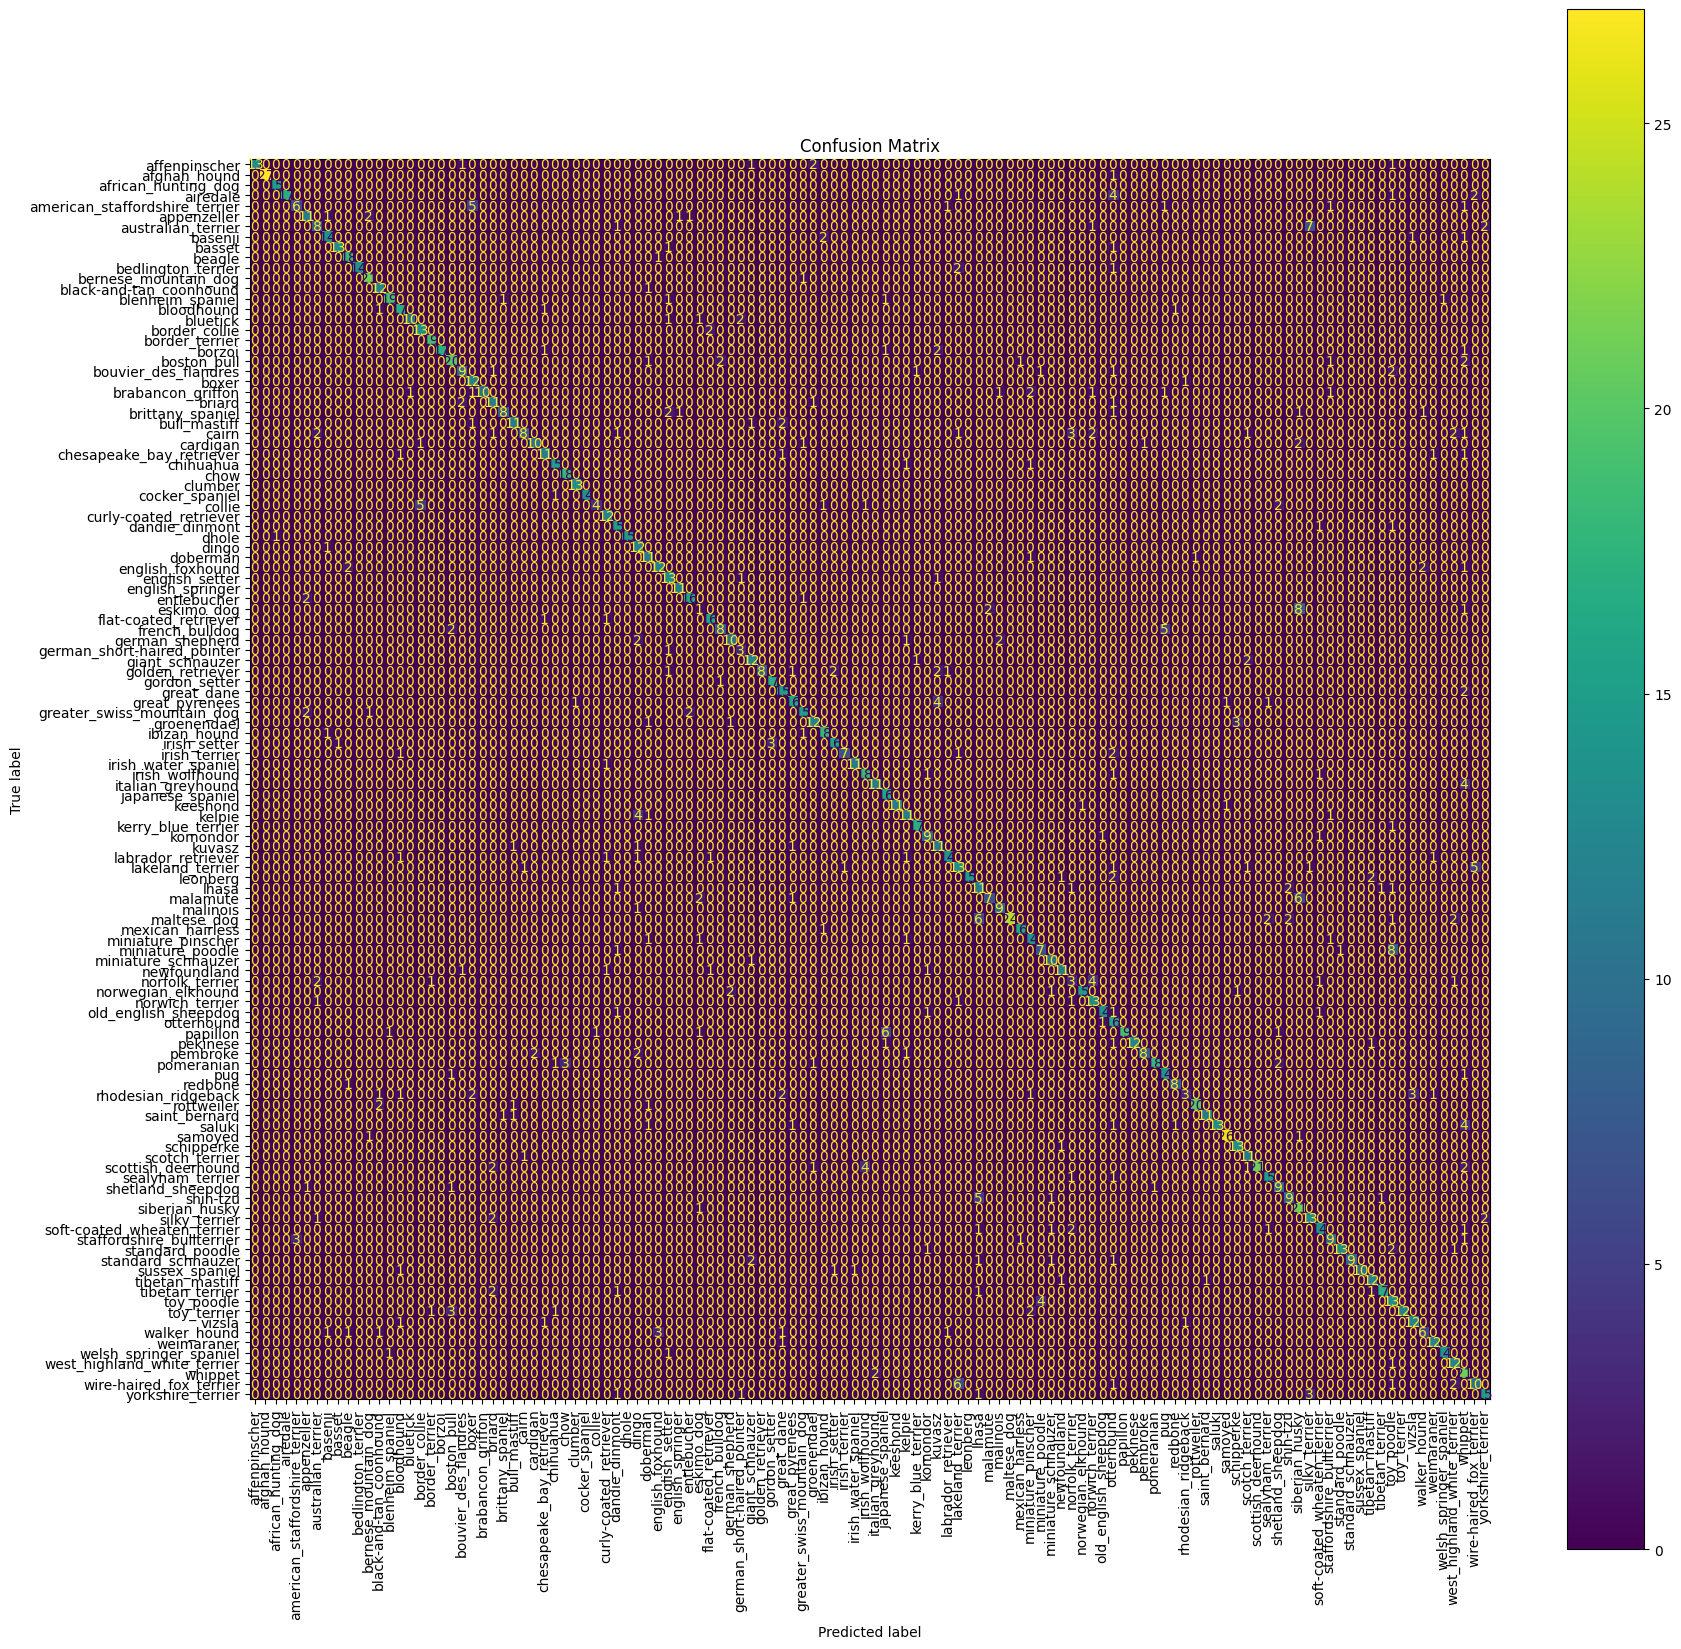

In [70]:
figsize = (20,20)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(cmap='viridis',ax=ax,xticks_rotation='vertical')
plt.title('Confusion Matrix')

In [72]:
import keras
model_plain.save("model_plain.keras")
loaded_model = keras.saving.load_model("model_plain.keras")

c:\Users\mathi\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [73]:
#eval
loss, accuracy = loaded_model.evaluate(x=x_test,y=y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 503ms/step - accuracy: 0.7568 - loss: 1.1673
Test loss: 1.1733
Test accuracy: 0.7584
